In [1]:
from scipy.stats import rv_continuous
import numpy as np

class frechet_distribution_gen(rv_continuous):
    "Frechet distribution"
    def _pdf(self, x, shape, scale_param):
        return scale_param * shape * x ** (-1 - shape) * np.exp(- scale_param * x ** -shape)
    
    def _cdf(self, x, shape, scale_param):
        return np.exp(- scale_param * x ** -shape)
    
    def _get_support(self, *args):
        return (0, np.inf)

# Create a frozen instance of our distribution
frechet_distribution = frechet_distribution_gen(name='frechet')

def frechet_draws(shape, scale_param, size=1):
    return frechet_distribution.rvs(shape, scale_param, size=size)

def draw_samples(shape, scale_matrix, size=1):
    # Initialize an array to store the samples
    samples = np.empty(scale_matrix.shape)

    # Draw samples for each scale parameter in the matrix
    for i in range(scale_matrix.shape[0]):
        for j in range(scale_matrix.shape[1]):
            samples[i, j] = frechet_distribution.rvs(shape, scale_matrix[i, j], size=size)

    return samples

In [2]:
def simulate_city(n_sectors, n_tech, tech_correlation, sector_weights, city_elasticity, expenditure_draws=None, shape=2.0, seed=123, random=0):
    import numpy as np 
    import random

    # Set the seed if not random
    if random == 0:
        np.random.seed(seed)
    elif random == 1:
        np.random.seed()

    # Check if the number of technologies matches the number of correlations
    if len(tech_correlation) != n_tech:
        raise ValueError("The number of technology correlations must match the number of technologies")
    for value in tech_correlation:
        if not 0 <= value <= 1:
            raise ValueError("All values in the tech_correlation array must be between 0 and 1")

    # Generate expenditure draws if not provided
    if expenditure_draws is None:
        expenditure_draws = np.random.normal(loc=0, scale=10, size=n_tech)
        expenditure_draws = np.array([np.absolute(expenditure_draws)])
    elif len(expenditure_draws) != n_tech:
        raise ValueError("The number of expenditure draws must match the number of technologies")

    # Generate sector specific weight draws
    if len(sector_weights) != n_sectors:
        raise ValueError("The number of sector weights must match the number of sectors")
    sector_weights = sector_weights

    #Covert elaticities
    city_elasticity = 1 / (1 - city_elasticity)
    tech_correlation = np.reciprocal(np.subtract(1, tech_correlation))

    # Calculate weighted endowments
    weighted_endowments = expenditure_draws * sector_weights

    # Calculate powered weighted endowments
    powered_weights = np.power(weighted_endowments, tech_correlation)
    powered_weights = np.power(powered_weights, city_elasticity)

    # Generate productivity draws
    productivity_draws = draw_samples(shape * city_elasticity, powered_weights)

    # Assign an ID
    hex_value = hex(random.randint(0, 16**6))[2:]

    return {
        "id": hex_value,
        "expenditure_draws": expenditure_draws,
        "sector_weights": sector_weights,
        "tech_correlation": tech_correlation,
        "productivity_draws": productivity_draws
    }


def simulate_person(n_tech):
    import numpy as np 
    import random

    # Generate endowment draws
    endowment_draws = np.random.normal(loc=0, scale=100, size=n_tech)
    endowment_draws = np.array([np.absolute(endowment_draws)])

    # Assign an ID
    hex_value = hex(random.randint(0, 16**6))[2:]

    return {
        "id": hex_value,
        "endowment_draws": endowment_draws
    }


def solve_wages(city, person):
    import numpy as np

    # if city['productivity_draws'].shape[1] != person['endowment_draws'].shape[1]:
    #     raise ValueError("The shape of the city and person productivity draws must match")

    wages = city['productivity_draws'] @ person['endowment_draws'].T

    max_indus = np.argmax(wages)
    max_wage = wages[max_indus]

    return {
        "person_id" : person['id'],
        "city_id" : city['id'],
        "max_wage": max_wage,
        "max_indus": max_indus,
        "wages": wages
    }

def assign_max_city_and_wage(people, cities, city_names=None):
    import random
    import geonamescache
    # Get a list of all city names
    gc = geonamescache.GeonamesCache()
    cities = gc.get_cities()
    actual_city_names = [city['name'] for city in cities.values()]

    # If city_names is not provided, draw from the pool of actual city names
    if city_names is None:
        city_names = random.choices(actual_city_names, k=len(cities))

    for person in people:
        wages_in_cities = []
        for i in range(len(cities)):
            solved_wages = solve_wages(cities[i], person)
            wages_in_cities.append((city_names[i], solved_wages['city_id'], solved_wages['max_wage'], solved_wages['max_indus']))
        max_wage_info = max(wages_in_cities, key=lambda x: x[2])
        max_city, max_city_id, max_wage, max_industry = max_wage_info
        person['max_city'] = max_city
        person['max_city_id'] = max_city_id
        person['max_wage'] = max_wage
        person['max_industry'] = max_industry

    return people

In [3]:
#Assume technology 1 is trade skills and technology 2 is service skills 

#Generate a service focused city with productivity draws
np.random.seed(120)

n_sectors = 10
n_tech = 2
tech_correlation = [0.5, 0.5]
sector_weights = np.random.dirichlet(np.ones(n_tech), size=n_sectors)
city_elasticity = 0.5
expenditure = [10, 20]

new_york = simulate_city(n_sectors, n_tech, tech_correlation, sector_weights, city_elasticity, expenditure_draws=expenditure)

print(f"Sector Weights: \n {new_york['sector_weights']}")
print()
print(f"New York Productivities: \n {new_york['productivity_draws']}")

Sector Weights: 
 [[0.61165056 0.38834944]
 [0.60115987 0.39884013]
 [0.16988792 0.83011208]
 [0.68403117 0.31596883]
 [0.79744481 0.20255519]
 [0.81576603 0.18423397]
 [0.45078106 0.54921894]
 [0.1242403  0.8757597 ]
 [0.14814544 0.85185456]
 [0.91336749 0.08663251]]

New York Productivities: 
 [[ 5.16858665  6.93462031]
 [ 6.61484284  8.9722532 ]
 [ 1.90528423 15.11104611]
 [ 8.12765394  8.20102293]
 [ 6.21604765  3.69745474]
 [ 7.00508043  9.08481457]
 [ 5.89409054  8.74373185]
 [ 1.41116913 14.82430908]
 [ 1.21190624 20.44773451]
 [16.57289091  3.08515745]]


/tmp/ipykernel_584906/1876812766.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  samples[i, j] = frechet_distribution.rvs(shape, scale_matrix[i, j], size=size)


In [4]:
#Generate two trade focused cities with productivity draws (Expected Wages)

expenditure = [20, 10]

detriot = simulate_city(n_sectors, n_tech, tech_correlation, sector_weights, city_elasticity, expenditure_draws=expenditure)
flint = simulate_city(n_sectors, n_tech, tech_correlation, sector_weights, city_elasticity, expenditure_draws=expenditure)

print(f"Detriot Productivities: \n {detriot['productivity_draws']}")
print()
print(f"Flint Productivities: \n {flint['productivity_draws']}")

Detriot Productivities: 
 [[ 9.99680284  3.80898653]
 [11.17871411  3.71436649]
 [ 2.97033442  6.39611029]
 [20.39495221  3.35826752]
 [21.81515675  2.89358966]
 [12.67693245  1.96461515]
 [ 8.55898225  8.68578853]
 [ 2.40406922 11.22590632]
 [ 2.85609395 12.44756057]
 [13.09528964  0.77254143]]

Flint Productivities: 
 [[14.90722982  5.05707253]
 [11.5446762   3.36996529]
 [ 4.02523525  8.76096638]
 [12.51512222  2.93593033]
 [24.137889    2.433364  ]
 [11.32895264  1.48625495]
 [ 6.02494425  4.77813131]
 [ 2.47264806  6.99768695]
 [ 2.79433201  9.98555346]
 [24.88898041  1.33501589]]


/tmp/ipykernel_584906/1876812766.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  samples[i, j] = frechet_distribution.rvs(shape, scale_matrix[i, j], size=size)


In [5]:
# Generate 100 people with endowment draws

n_people = 100
people = [simulate_person(n_tech) for i in range(n_people)]

# 50 people will have skills focused on trades and 50 people will have skills focused on services
for i in range(n_people):
    if i < 50:
        # Add 1 to the first endowment and label as 'trade'
        people[i]['endowment_draws'] = people[i]['endowment_draws'].flatten()
        people[i]['endowment_draws'][0] += 5
        people[i]['label'] = 'trade'
    else:
        # Add 1 to the second endowment and label as 'services'
        people[i]['endowment_draws'] = people[i]['endowment_draws'].flatten()
        people[i]['endowment_draws'][1] += 5
        people[i]['label'] = 'services'

In [6]:
# Solve wages for ever single person in every city

cities = [new_york, detriot, flint]
city_names = ['New York', 'Detriot', 'Flint']

for person in people:
    wages_in_cities = []
    for i in range(len(cities)):
        solved_wages = solve_wages(cities[i], person)
        wages_in_cities.append((city_names[i], solved_wages['city_id'], solved_wages['max_wage'], solved_wages['max_indus']))
    max_wage_info = max(wages_in_cities, key=lambda x: x[2])
    max_city, max_city_id, max_wage, max_industry = max_wage_info
    person['max_city'] = max_city
    person['max_city_id'] = max_city_id
    person['max_wage'] = max_wage
    person['max_industry'] = max_industry

In [7]:
# test_people = assign_max_city_and_wage(people, cities, city_names)

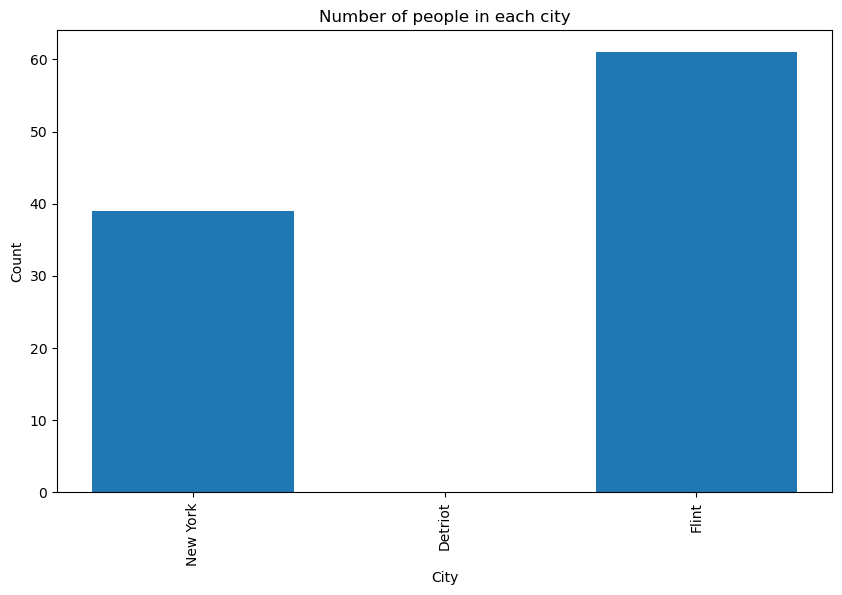

   max_city  counts
0     Flint      61
1  New York      39


In [8]:
# Visualize where different types of people end up

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame with city names
city_df = pd.DataFrame(city_names, columns=['max_city'])

# Assuming 'people' is a list of dictionaries and each dictionary has keys 'max_city' and 'type'
df = pd.DataFrame(people)

# Count the number of people in each city
counts = df.groupby('max_city').size().reset_index(name='counts')

# Merge the city_df with counts
city_df = city_df.merge(counts, on='max_city', how='left')

# Fill NaN values with 0
city_df['counts'] = city_df['counts'].fillna(0)

# Plot the counts of people in each city
plt.figure(figsize=(10,6))
plt.bar(city_df['max_city'], city_df['counts'])
plt.xlabel('City')
plt.ylabel('Count')
plt.title('Number of people in each city')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()

print(counts)

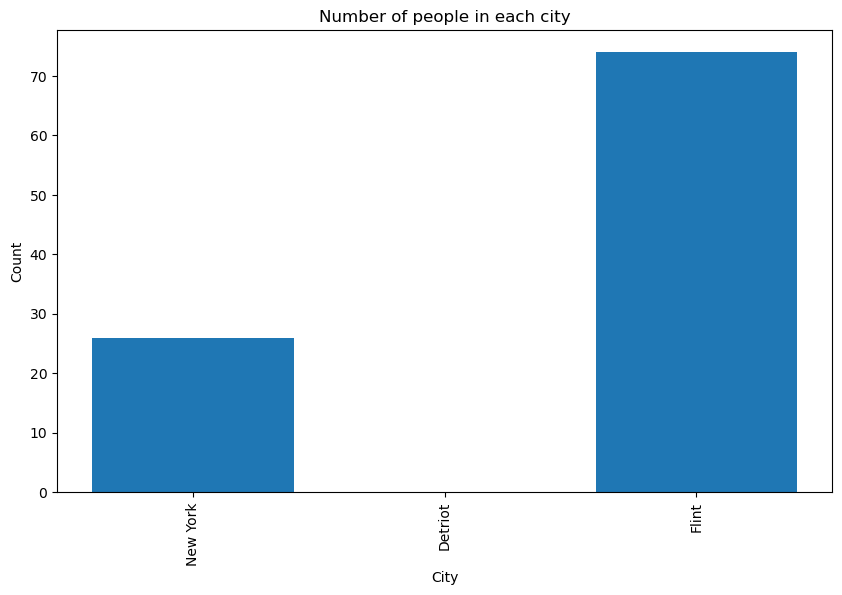

   max_city  counts
0     Flint      74
1  New York      26


In [10]:
# Induce a negative shock to flint

multiplier = 2
flint['productivity_draws'] = flint['productivity_draws'] * multiplier

# Resolve wages for every person in every city
cities = [new_york, detriot, flint]
city_names = ['New York', 'Detriot', 'Flint']

for person in people:
    wages_in_cities = []
    for i in range(len(cities)):
        solved_wages = solve_wages(cities[i], person)
        wages_in_cities.append((city_names[i], solved_wages['city_id'], solved_wages['max_wage'], solved_wages['max_indus']))
    max_wage_info = max(wages_in_cities, key=lambda x: x[2])
    max_city, max_city_id, max_wage, max_industry = max_wage_info
    person['max_city'] = max_city
    person['max_city_id'] = max_city_id
    person['max_wage'] = max_wage
    person['max_industry'] = max_industry

# Plot results 
# Create a DataFrame with city names
city_df = pd.DataFrame(city_names, columns=['max_city'])

# Assuming 'people' is a list of dictionaries and each dictionary has keys 'max_city' and 'type'
df = pd.DataFrame(people)

# Count the number of people in each city
counts = df.groupby('max_city').size().reset_index(name='counts')

# Merge the city_df with counts
city_df = city_df.merge(counts, on='max_city', how='left')

# Fill NaN values with 0
city_df['counts'] = city_df['counts'].fillna(0)

# Plot the counts of people in each city
plt.figure(figsize=(10,6))
plt.bar(city_df['max_city'], city_df['counts'])
plt.xlabel('City')
plt.ylabel('Count')
plt.title('Number of people in each city')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()

print(counts)

Consumers draw from some bivariate normal. 
Just choose cities, not sectors. Hide the sectors, just get some expeteed wage. Just utility of expected wage. How willing are you to substitue across sectors.

Don't make detriot and flint the same.
Change to the new household formulation.
Read guangbin, where does he put frechet.

If new york is 10% of the population, the there's a 10% chnace I move to New York.

Make expenditure sector specific.

Restate pg 322 from Lind & Ramondo in terms of workers and cities.